Test daily surface salinity plot with different river treatments

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,stormtools,tidetools)
from salishsea_tools.nowcast import figures
from datetime import datetime, timedelta
from pylab import *
from sklearn import linear_model
from glob import glob
from IPython.core.display import HTML
import datetime
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import math
#import glob
import os
import datetime
%matplotlib inline

for new model result with new bathymetry of Fraser

In [2]:
def results_dataset(period, grid, results_dir):
    """Return the results dataset for period (e.g. 1h or 1d)
    and grid (e.g. grid_T, grid_U) from results_dir.
    """
    filename_pattern = 'SalishSea_{period}_*_{grid}.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(period=period, grid=grid)))
    return  nc.Dataset(filepaths[0])

In [3]:
run_date = datetime.datetime(2015,6,15)
# New results dataset location
results_home = '/ocean/jieliu/research/meopar/river-treatment/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())

In [4]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/ocean/jieliu/research/meopar/river-treatment/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [5]:
grid_T_hr= results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea3.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
filepath_name

['/ocean/jieliu/research/meopar/river-treatment/15jun15/SalishSea_1h_20150615_20150615_grid_T.nc']

In [6]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [7]:
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

for original model result

In [19]:
def date(year, month, day_start, day_end, period, grid):
    
    day_range = np.arange(day_start, day_end+1)
    day_len = len(day_range)
    files_all = [None] * day_len
    inds = np.arange(day_len)
    
    for i, day in zip(inds, day_range):
        run_date = datetime.datetime(year,month, day)
        results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
        results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
        filename = 'SalishSea_' + period + '_' + run_date.strftime('%Y%m%d').lower() + \
        '_' + run_date.strftime('%Y%m%d').lower() + '_' + grid + '.nc'
        file_single = os.path.join(results_dir, filename)
        files_all[i] = file_single

    return files_all

In [20]:
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())
grid_T_hr = results_dataset('1h', 'grid_T', results_dir)
bathy = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
PNW_coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')
filepath_name = date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 

In [21]:
latitude=grid_T_hr.variables['nav_lat'] 
longitude=grid_T_hr.variables['nav_lon']

In [22]:
sal_hr = grid_T_hr.variables['vosaline']
t, z = 3, 0
sal_hr = np.ma.masked_values(sal_hr[t, z], 0)

prepare salinity data

In [8]:
saline=sio.loadmat('/ocean/jieliu/research/meopar\
/autodataupdate/ferrydata/SBE1920150614.mat')

In [9]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd):
    k=0
    values =0
    valuess=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    regr =linear_model.LinearRegression()
    regr.fit(lon11,lat11);
    regr.coef_

    [x1, j1] = tidetools.find_closest_model_point(lon11[q],regr.predict(lon11[q]),\
                                        X,Y,bathy,lon_tol=0.0052,lat_tol=0.00210,allow_land=False)
    for i in np.arange(x1-1,x1+2):
        for j in np.arange(j1-1,j1+2):
            dist[k]=tidetools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            values=values+value_3rd[k]
            valuess=valuess+value_4rd[k]
            k+=1
            
    return values, valuess, weights

In [10]:
def get_SS2_bathy_data():
    """Get the original Salish Sea 2 bathymetry and grid data
    e.g. bathy, X, Y = get_SS2_bathy_data()

    .. note::

        This function is deprecated due to hard-coding of
        :file:`/ocean/klesouef/` path.
        Use :py:func:`tidetools.get_bathy_data` instead.

    :returns: bathy, X, Y
    """
    grid = nc.Dataset(
        '/ocean/jieliu/research/meopar/nemo-forcing/grid/bathy_meter_SalishSea2.nc', 'r')
    bathy = grid.variables['Bathymetry'][:, :]
    X = grid.variables['nav_lon'][:, :]
    Y = grid.variables['nav_lat'][:, :]
    return bathy, X, Y

In [11]:
def get_SS3_bathy_data():
    """Get the Salish Sea 3 bathymetry and grid data
    e.g. bathy, X, Y = get_SS3_bathy_data()

    .. note::

        This function is deprecated due to hard-coding of
        :file:`/ocean/klesouef/` path.
        Use :py:func:`tidetools.get_bathy_data` instead.

    :returns: bathy, X, Y
    """
    grid = nc.Dataset(
        '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea3.nc', 'r')
    bathy = grid.variables['Bathymetry'][:, :]
    X = grid.variables['nav_lon'][:, :]
    Y = grid.variables['nav_lat'][:, :]
    return bathy, X, Y

In [12]:
def salinity_fxn(saline):
    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]
    
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        
        if((python_datetime.year == run_date.year) & (python_datetime.month == run_date.month)\
           & (python_datetime.day == run_date.day)
           & (python_datetime.hour >= 3))&(python_datetime.hour < 5):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    lon11=lon1_2_4[0:-1:50]
    lat11=lat1_2_4[0:-1:50]
    salinity11=salinity1_2_4[0:-1:50]
    if results_home == '/ocean/jieliu/research/meopar/river-treatment/': 
        bathynew, X, Y = get_SS3_bathy_data()
    else:
        bathyold, X, Y = get_SS2_bathy_data()
    
    #bathy, X, Y = tidetools.get_SS2_bathy_data()## problem!!!!!
    
    #aa, bathy_file=date(run_date.year,run_date.month,run_date.day,run_date.day,'1h','grid_T') 
    #sim_date = datetime.datetime(2015,3,19)####need to change for \
    #different daily model results, construct a datetime object
    #run_date = datetime.datetime(2015,3,19)
    
    date_str = run_date.strftime('%d-%b-%Y') ##create a string based on this date
    tracers=nc.Dataset(filepath_name[0])
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']
    saline_nemo_3rd = saline_nemo[3,0, 0:898, 0:398] 
    saline_nemo_4rd = saline_nemo[4,0, 0:898, 0:398]
    
    matrix=np.zeros([15,9])
    values=np.zeros([15,1])
    valuess=np.zeros([15,1])
    value_mean_3rd_hour=np.zeros([15,1])
    value_mean_4rd_hour=np.zeros([15,1]) 
    for q in np.arange(0,15):
        if results_home == '/ocean/jieliu/research/meopar/river-treatment/': 
            
            values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathynew, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
            value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
            value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])
        else:
            values[q], valuess[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                     bathyold, longitude, latitude, saline_nemo_3rd, saline_nemo_4rd)
            value_mean_3rd_hour[q]=values[q]/sum(matrix[q])
            value_mean_4rd_hour[q]=valuess[q]/sum(matrix[q])

    return lon11, lat11, value_mean_3rd_hour, value_mean_4rd_hour, salinity11, date_str

In [23]:
lon11, lat11, value_mean_3rd_hour, value_mean_4rd_hour, salinity11, date_str = salinity_fxn(saline)

(15, 1)


plot

In [14]:
# Hides Deprecation warming - needs fixing
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [15]:
# Dictionary of ferry stations - new
ferry_stations = {'Tsawwassen': {'lat': 49.0084,'lon': -123.1281},
                  'Duke': {'lat': 49.1632,'lon': -123.8909},
                  'Vancouver': {'lat': 49.2827,'lon': -123.1207}}

In [16]:
def salinity_ferry_route(grid_T, grid_B, PNW_coastline, ferry_sal):
    """ plot daily salinity comparisons between ferry observations 
    and model results as well as ferry route with model salinity 
    distribution.
    
    :arg grid_B: Bathymetry dataset for the Salish Sea NEMO model.
    :type grid_B: :class:`netCDF4.Dataset`
    
    :arg PNW_coastline: Coastline dataset.
    :type PNW_coastline: :class:`mat.Dataset`
    
    :arg ferry_sal: saline
    :type ferry_sal: numpy
    
    :returns: fig
    """

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    figures.plot_map(axs[1], grid_B, PNW_coastline)
    axs[1].set_xlim(-124.5, -122.5)
    axs[1].set_ylim(48.2, 49.5)
    viz_tools.set_aspect(axs[1],coords='map',lats=latitude)
    cmap=plt.get_cmap('spectral')
    cmap.set_bad('burlywood')
    mesh=axs[1].pcolormesh(longitude[:],latitude[:],sal_hr[:],cmap=cmap)
    cbar=fig.colorbar(mesh)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('Pratical Salinity', color='white')
    
    axs[1].set_title('Ferry Route: 3am[UTC] model result ', **title_font)
 
    bbox_args = dict(boxstyle='square', facecolor='white', alpha=0.7)
    stations=['Tsawwassen','Duke','Vancouver']
    for stn in stations:
        axs[1].plot(ferry_stations[stn]['lon'], ferry_stations[stn]['lat'], marker='D', \
                    color='white',\
                 markersize=10, markeredgewidth=2)
    axs[1].annotate ('Tsawwassen',(ferry_stations['Tsawwassen']['lon'] + 0.02,\
    ferry_stations['Tsawwassen']['lat'] + 0.12), fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Duke',(ferry_stations['Duke']['lon'] - 0.35,\
    ferry_stations['Duke']['lat'] ),fontsize=15, color='black', bbox=bbox_args )
    axs[1].annotate ('Vancouver',(ferry_stations['Vancouver']['lon'] - 0.1,\
    ferry_stations['Vancouver']['lat']+ 0.09 ),fontsize=15, color='black', bbox=bbox_args )
    figures.axis_colors(axs[1], 'white')
    
    
    lon11, lat11, value_mean_3rd_hour, value_mean_4rd_hour, salinity11, date_str = salinity_fxn(saline)
    axs[1].plot(lon11,lat11,'black', linewidth = 4)
    model_salinity_3rd_hour=axs[0].plot(lon11,value_mean_3rd_hour,'DodgerBlue',\
                                    linewidth=2, label='3 am [UTC]')
    model_salinity_4rd_hour=axs[0].plot(lon11,value_mean_4rd_hour,'MediumBlue',\
                                        linewidth=2, label="4 am [UTC]" )
    observation_salinity=axs[0].plot(lon11,salinity11,'DarkGreen', linewidth=2, label="Observed")
    axs[0].text(0.25, -0.1,'Observations from Ocean Networks Canada', \
                transform=axs[0].transAxes, color='white')

    axs[0].set_xlim(-124, -123)
    axs[0].set_ylim(0, 30)
    axs[0].set_title('Surface Salinity: ' + date_str, **title_font)
    axs[0].set_xlabel('Longitude', **axis_font)
    axs[0].set_ylabel('Practical Salinity', **axis_font)
    axs[0].legend()
    axs[0].grid()
   

    fig.patch.set_facecolor('#2B3E50')
    figures.axis_colors(axs[0], 'gray')
    
    return fig

In [17]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13'}

new and old surface salinity comparison plot

/home/jieliu/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jieliu/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


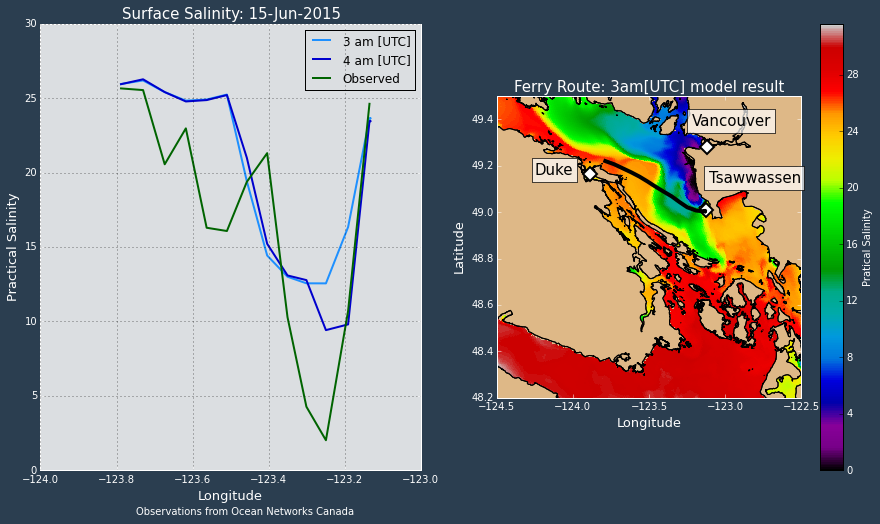

In [18]:
##new model result 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, saline)

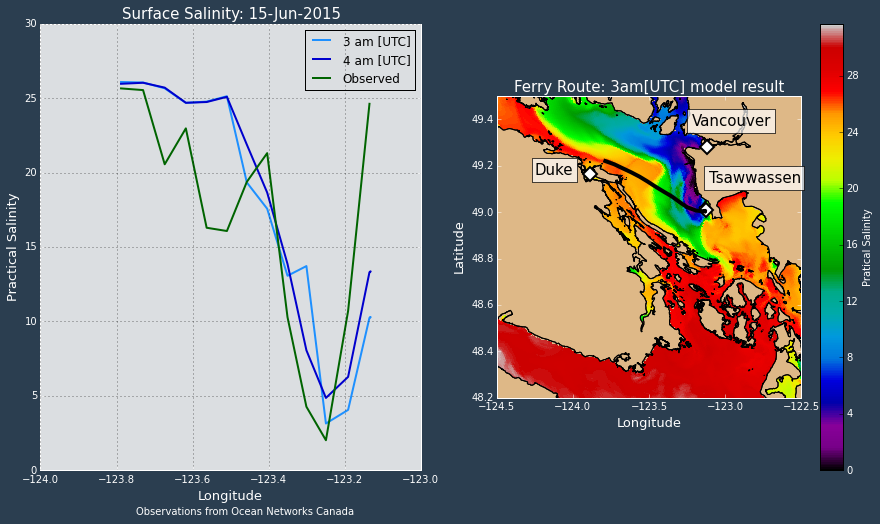

In [24]:
#old model result 
fig = salinity_ferry_route(grid_T_hr, bathy, PNW_coastline, saline)